Diagnóstico del cáncer de mama
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-analytics/blob/master/01-kNN-R-breast-cancer.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-analytics/blob/master/01-kNN-R-breast-cancer.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-analytics/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-analytics/blob/master/readme.md)

# Definición del problema real

Se desea determinar si una masa mamaria es un tumor benigno o maligno, a partir de las medidas obtenidas de imágenes digitalizadas de la aspiración con una aguja fina. Los valores representan las características de los núcleos celulares presentes en la imagen digital. 

# Definición del problema en términos de los datos

Se tiene una muestra de 569 ejemplos de resultados de las biopsias. Cada registro contiene 32 variables, las cuales corresponden a tres medidas (media, desviación estándar, peor caso) de diez características diferentes (radius, texture, ...).

* Identification number
* Cancer diagnosis ("M" para maligno y "B" para benigno)
* Radius
* Texture
* Perimeter
* Area
* Smoothness
* Compactness
* Concavity
* Concave points
* Symmetry
* Fractal dimension

En términos de los datos, se desea pronosticar si una masa es benigna o maligna (clase B o M) a partir de las 30 variables.

Fuente de los datos: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

# Exploración

In [1]:
## Carga de los datos
wbcd <- read.csv("data/wisc_bc_data.csv", 
                 stringsAsFactors = FALSE)

In [2]:
## Verificación de los datos cargados
## La columna diagnosis corresponde al dianóstico.
str(wbcd)

'data.frame':	569 obs. of  32 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : chr  "M" "M" "M" "M" ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se             : num  0.905 0.734 0.787 1

In [3]:
## Se excluye la primera columna ya que no es informativa
## (corresponde al id del caso).
wbcd <- wbcd[-1]

In [4]:
## Cantidad de casos para cada diagnóstico.
table(wbcd$diagnosis)


  B   M 
357 212 

In [5]:
## Se convierte la columna diagnosis de character a factor.
wbcd$diagnosis <- 
  factor(wbcd$diagnosis, 
         levels = c("B", "M"),              # las letras B y M se convierten en factores
         labels = c("Benign", "Malignant")) # se dan nuevos nombres a los factores

In [6]:
## Cantidad de casos para cada diagnostico.
## Note que los nombres son más informativos.
table(wbcd$diagnosis)


   Benign Malignant 
      357       212 

In [7]:
## Se convierte el conteo en probabilidades.
round(prop.table(table(wbcd$diagnosis)) * 100, digits = 1)


   Benign Malignant 
     62.7      37.3 

# Metodología k-NN

El problema en términos matemáticos se define de la siguiente forma. 
* Se tienen $M$ ejemplos (las 569 observaciones del problema analizado).  
* Cada ejemplo esta definido por un conjunto de variables ($x_1$, $x_2$, ..., $x_N$); es decir, las 30 columnas de datos.
* Cada ejemplo pertenece a una clase y hay $P$ clases diferentes; en el caso analizado sólo hay dos clases: benigno o maligno. 
* Para un nuevo caso (tumor) y con base en las 30 mediciones realizadas (variables), se desea pronosticar a que clase pertenece (maligno o benigno). 

El método k-NN asígna una clase (de las $P$ posibles) al nuevo ejemplo en dos pasos. En el primer paso, determina los $k$ ejemplos más cercanos (distancia) al nuevo ejemplo; en el segundo paso, asigna la clase al nuevo punto por mayoría; es decir, asigna la clase con mayor frecuencia entre los $k$ vecinos más cercnos. Por ejemplo, si se consideran 7 vecinos, de los cuales 5 son "benignos" (y 2 "malignos") entonces el nuevo punto es clasificado como "benigno".

La lógica de este método se basa en el siguiente razonamiento: Si un nuevo patrón (ejemplo) es más cercano en distancia a los ejemplos de la clase A que a los ejemplos de la clase B, entonces pertenece a la clase A y viceversa. En la siguiente figura, el punto azul se asignaría a la clases 2 y el punto rojo a la clase 1.

![alt text](images/kmeans.jpg)

Desafortunadamente, el método no es capaz de detectar patrones que son lejanos de los patrones de entrenamiento, tal como ocurre para el punto verde de la figura anterior.  

La distancia entre dos puntos $p$ y $q$ es:

$$dist(p, q) = \sqrt{\sum_{i=1}^N (p_i - q_i)^2}$$


**Ejercicio.** ¿Cómo se implementa computacionalmente este algoritmo?

Ya que la escala de las variables numéricas afecta la medición, se pueden realizar dos transformaciones:

**Normalización min-max**.

$$z_j = \frac{x - \text{min}(x_j)}{\text{max}(x_j) - \text{min}(x_j)}$$ 

**Estandarización z.**

$$z_j = \frac{x - \text{mean}(x_j)}{\text{std}(x_j) }$$ 



Para variables nominales que representan $S$ categorías se crean $S-1$ variables: la primera variable vale 1 si la variable nominal toma el valor de la primera categoría; la segunda variable vale 2 si la variable nominal toma el valor de la segunda categoría, y así sucesivamente. ¿Por qué se requieren $S-1$ variables para $S$ categorías de la variable nominal?.  

# Preparación de los datos

In [8]:
## se examina el rango de las variables
summary(wbcd[2:31])

  radius_mean      texture_mean   perimeter_mean     area_mean     
 Min.   : 6.981   Min.   : 9.71   Min.   : 43.79   Min.   : 143.5  
 1st Qu.:11.700   1st Qu.:16.17   1st Qu.: 75.17   1st Qu.: 420.3  
 Median :13.370   Median :18.84   Median : 86.24   Median : 551.1  
 Mean   :14.127   Mean   :19.29   Mean   : 91.97   Mean   : 654.9  
 3rd Qu.:15.780   3rd Qu.:21.80   3rd Qu.:104.10   3rd Qu.: 782.7  
 Max.   :28.110   Max.   :39.28   Max.   :188.50   Max.   :2501.0  
 smoothness_mean   compactness_mean  concavity_mean    concave.points_mean
 Min.   :0.05263   Min.   :0.01938   Min.   :0.00000   Min.   :0.00000    
 1st Qu.:0.08637   1st Qu.:0.06492   1st Qu.:0.02956   1st Qu.:0.02031    
 Median :0.09587   Median :0.09263   Median :0.06154   Median :0.03350    
 Mean   :0.09636   Mean   :0.10434   Mean   :0.08880   Mean   :0.04892    
 3rd Qu.:0.10530   3rd Qu.:0.13040   3rd Qu.:0.13070   3rd Qu.:0.07400    
 Max.   :0.16340   Max.   :0.34540   Max.   :0.42680   Max.   :0.20120    

In [9]:
labels

function (object, ...) 
UseMethod("labels")
<bytecode: 0x7fae2c776c98>
<environment: namespace:base>

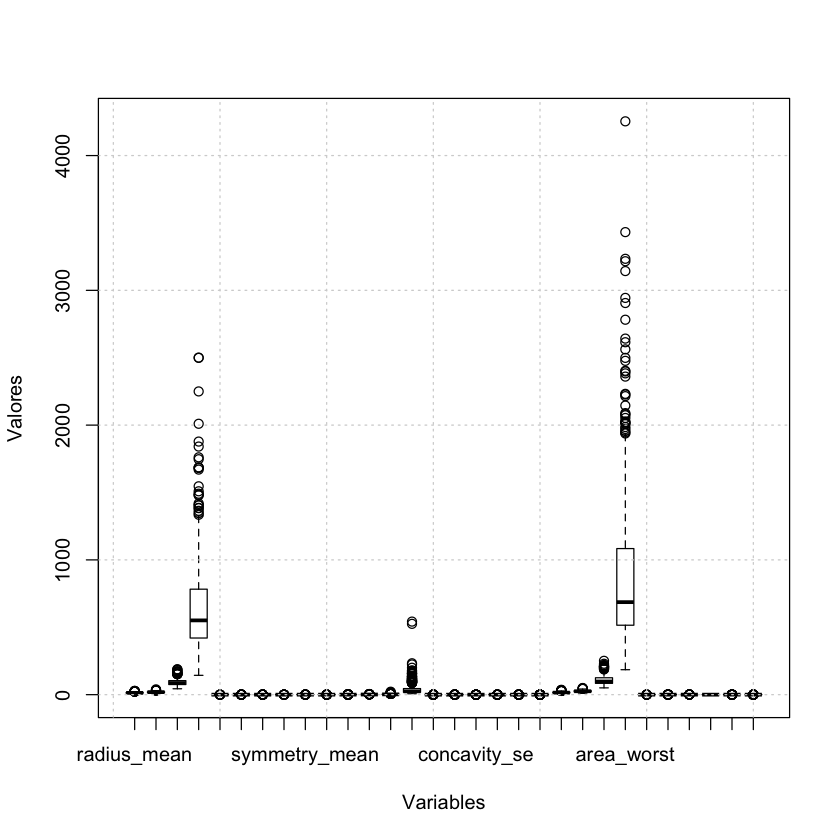

In [10]:
## Para las variables numéricas (todas en este
## caso) se puede construir un diagrama de
## caja y bigotes.
plt <- boxplot(wbcd[,-1], 
               xlab="Variables", 
               ylab="Valores",
               srt = 90,
               horiz=FALSE)
grid()

Note que la información visualizada muestra que las variables tienen diferentes rangos, lo que afecta la medición de las distancias, y habría variables que pesarían más en la medición respecto a otras. Para corregir este problema se normalizan las variables.

In [11]:
# se define la función de normalización
normalize <- 
function(x) {
    return ((x - min(x)) / (max(x) - min(x)))
}

In [12]:
# se aplica la función a los datos
wbcd_n <- as.data.frame(lapply(wbcd[2:31], normalize))
head(wbcd_n)

radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,⋯,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
0.5210374,0.0226581,0.5459885,0.3637328,0.5937528,0.7920373,0.7031396,0.7311133,0.6863636,0.6055181,⋯,0.6207755,0.1415245,0.6683102,0.45069799,0.6011358,0.6192916,0.5686102,0.9120275,0.5984624,0.4188640
0.6431445,0.2725736,0.6157833,0.5015907,0.2898799,0.1817680,0.2036082,0.3487575,0.3797980,0.1413227,⋯,0.6069015,0.3035714,0.5398177,0.43521431,0.3475533,0.1545634,0.1929712,0.6391753,0.2335896,0.2228781
0.6014956,0.3902604,0.5957432,0.4494168,0.5143089,0.4310165,0.4625117,0.6356859,0.5095960,0.2112468,⋯,0.5563856,0.3600746,0.5084417,0.37450845,0.4835898,0.3853751,0.3597444,0.8350515,0.4037059,0.2134330
0.2100904,0.3608387,0.2335015,0.1029056,0.8113208,0.8113613,0.5656045,0.5228628,0.7762626,1.0000000,⋯,0.2483102,0.3859275,0.2413467,0.09400806,0.9154725,0.8140117,0.5486422,0.8848797,1.0000000,0.7737111
0.6298926,0.1565776,0.6309861,0.4892895,0.4303512,0.3478928,0.4639175,0.5183897,0.3782828,0.1868155,⋯,0.5197439,0.1239339,0.5069476,0.34157491,0.4373638,0.1724151,0.3194888,0.5584192,0.1575005,0.1425948
0.2588386,0.2025702,0.2679842,0.1415058,0.6786133,0.4619962,0.3697282,0.4020378,0.5186869,0.5511794,⋯,0.2682319,0.3126333,0.2639076,0.13674794,0.7127386,0.4827837,0.4277157,0.5982818,0.4770353,0.4549390


In [13]:
# se verifica la transformación
summary(wbcd_n)

  radius_mean      texture_mean    perimeter_mean     area_mean     
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.2233   1st Qu.:0.2185   1st Qu.:0.2168   1st Qu.:0.1174  
 Median :0.3024   Median :0.3088   Median :0.2933   Median :0.1729  
 Mean   :0.3382   Mean   :0.3240   Mean   :0.3329   Mean   :0.2169  
 3rd Qu.:0.4164   3rd Qu.:0.4089   3rd Qu.:0.4168   3rd Qu.:0.2711  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
 smoothness_mean  compactness_mean concavity_mean    concave.points_mean
 Min.   :0.0000   Min.   :0.0000   Min.   :0.00000   Min.   :0.0000     
 1st Qu.:0.3046   1st Qu.:0.1397   1st Qu.:0.06926   1st Qu.:0.1009     
 Median :0.3904   Median :0.2247   Median :0.14419   Median :0.1665     
 Mean   :0.3948   Mean   :0.2606   Mean   :0.20806   Mean   :0.2431     
 3rd Qu.:0.4755   3rd Qu.:0.3405   3rd Qu.:0.30623   3rd Qu.:0.3678     
 Max.   :1.0000   Max.   :1.0000   Max.   :1.00000   Max.   :1.0000     
 symme

In [14]:
# se crean los conjuntos de entrenamiento y prueba
wbcd_train <- wbcd_n[1:469, ]
wbcd_test <- wbcd_n[470:569, ]

# clase de cada ejemplo
wbcd_train_labels <- wbcd[1:469, 1]
wbcd_test_labels <- wbcd[470:569, 1]

# Entrenamiento del modelo

Este no es propiamente un entrenamiento ya que no hay parámetros que estimar.

In [15]:
# carga la librería
# install.packages("class")
library(class)
wbcd_test_pred <- knn(train = wbcd_train,     # conjunto de entrenamiento
                      test = wbcd_test,       # conjutno de prueba
                      cl = wbcd_train_labels, # clases para el conjunto de entrenamiento
                      k = 21)                 # número de vecinos

# Evaluación del modelo

Para evaluar el desempeño en problemas de clasificación dicotómicos (dos clases mutuamente excluyentes) se usa la siguiente tabla:


             | Pronostico
             |  P     N
    ---------|------------  
          P  |  TP    FN          
    Real     |
          N  |  FP    TN
    
    TP - Verdadero positivo (correcto)
    TN - Verdadero negativo (correcto)
    FN - Falso negativo (mal clasificado)
    FP - Falso positivo (mal clasificado)
    
La medición de la precisión del modelo permite estimar el desempeño del modelo ante nuevos datos.

In [16]:
# Se calcula la matriz de confusión.
# La tabla indica que se calcularon 77+21 patrones 
# correctamente, y que dos tumores malignos se 
# dianosticaron como benignos. Se clasificaron
# cero tumores benignos como malignos.
table(wbcd_test_labels, wbcd_test_pred)

                wbcd_test_pred
wbcd_test_labels Benign Malignant
       Benign        77         0
       Malignant      2        21

A partir de la matriz de confusión es posible calcular diferentes métricas de error.

* Tasa de éxito (porcentaje de patrones clasificados correctamente):


$$\text{success rate} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

In [17]:
(77 + 21) / ( 77 + 21 + 2 + 0)

[1] 0.98

* Tasa de error (porcentaje de patrones clasificados incorrectamente):

$$\text{error rate} = \frac{\text{FP} + \text{FN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} = 1 - \text{accuracy}$$

In [18]:
(2 + 0) / ( 77 + 21 + 2 + 0)

[1] 0.02

* Predominio: número total de casos positivos pronósticados respecto al número total de casos.


$$\text{prevalence} = \frac{\text{TP} + \text{FN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Las siguientes dos métricas representan un balance entre lo conservador y agresivo de un clasificador. Es decir, se podría desear que se clasifique correctamente todas las masas mamarias benignas, pero esto implica que también se clasificarán como benignas masas cancerosas. De forma inversa, se puede desear que se clasifiquen correctamente todas las masas cancerosas, pero esto a su vez implica que algunas masas benignas se clasifiquen como cancerosas. 

In [19]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2


* Sensibilidad o tasa verdadera positiva: mide la proporción de ejemplos positivos que fueron correctamente clasificados.


$$\text{sensitibity} = \frac{\text{TP}}{\text{TP}  + \text{FN}}$$

In [20]:
77 / (77 + 0)

[1] 1

In [21]:
sensitivity(wbcd_test_pred, 
            wbcd_test_labels,
            positive = "Benign")

[1] 1

* Especifidad o tasa verdadera negativa: mide la proporción de ejemplos negativos correctamente clasificados.


$$\text{specifity} = \frac{\text{TN}}{\text{TN}  + \text{FP}}$$

In [22]:
21 / (21 + 2)

[1] 0.9130435

In [23]:
specificity(wbcd_test_pred, 
            wbcd_test_labels,
            positive = "Benign")

[1] 0.9130435

* Precisión o valor predictivo positivo: Proporción de casos positivos que fueron verdaderamente positivos.


$$\text{precision} = \frac{\text{TP}}{\text{TP}  + \text{FP}}$$

In [24]:
77 / (77 + 2)

[1] 0.9746835

In [25]:
posPredValue(wbcd_test_pred, 
             wbcd_test_labels,
             positive = "Bening",
             negative = "Malign")

[1] NA

* Valor predictivo negativo: Proporción de casos negativos que fueron verdaderamente negativos.


$$\text{negative predictive value} = \frac{\text{TN}}{\text{TN}  + \text{FN}}$$

In [26]:
21 / (21 + 0)

[1] 1

In [27]:
negPredValue(wbcd_test_pred, 
             wbcd_test_labels,
             positive = "Bening")

[1] 1

* La medida F permite comparar varios modelos entre si.


$$\text{F-measure} = \frac{2 * \text{TP}}{2 * \text{TP} + \text{FP} + \text{FN}}$$

**Ejercicio.--** La función CrossTable computa la matriz de confusión y entrega información detallada de los cálculos, tal como se muestra a continuación. Cómo se lee la tabla? Puede identificar las medidas de precisión anteriores en la tabla?

In [28]:
# La función CrossTable del paquete gmodels
# entrega información más detallada.
# install.packages("gmodels")
library(gmodels)
CrossTable(x = wbcd_test_labels, 
           y = wbcd_test_pred,
           prop.chisq=FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  100 

 
                 | wbcd_test_pred 
wbcd_test_labels |    Benign | Malignant | Row Total | 
-----------------|-----------|-----------|-----------|
          Benign |        77 |         0 |        77 | 
                 |     1.000 |     0.000 |     0.770 | 
                 |     0.975 |     0.000 |           | 
                 |     0.770 |     0.000 |           | 
-----------------|-----------|-----------|-----------|
       Malignant |         2 |        21 |        23 | 
                 |     0.087 |     0.913 |     0.230 | 
                 |     0.025 |     1.000 |           | 
                 |     0.020 |     0.210 |           | 
-----------------|-----------|-----------|-----------|
    Column Total |        79 |        21 |       100 | 
           

# Mejora del modelo

**Ejercicio.** Determine si el modelo mejora con $k$ = 21 y se estándarizan las variables (use la función `scale`). 

**Ejercicio.** Determine el valor óptimo de $k$ cuándo los datos son normalizados (Calcule la cantidad total de ejemplos mal clasificados para $k$ desde 1 hasta 27).

**Ejercicio.** Los resutados son dependientes de cómo se partieron los datos en entrenamiento y prueba. Cómo podría calcular de una forma más robusta la cantidad de vecinos?

---

Diagnóstico del cáncer de mama
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-analytics/blob/master/01-kNN-R-breast-cancer.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-analytics/blob/master/01-kNN-R-breast-cancer.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-analytics/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-analytics/blob/master/readme.md)